PAPER Henry Adams et al. “Persistence images: A stable vector representation of persistent homol-
ogy”. In: Journal of Machine Learning Research 18 (2017).

In [2]:
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

- CREATE CLASSES FROM A DYNAMICAL SYSTEM WITH DIFFERENT PAIRS OF PARAMETERS
- CREATE THEIR PERSISTENCE DIAGRAM
- COMPARE THEM: WASSERSTEIN AND BOTTOLNECK DISTANCE


> Point clouds generate for the same parameter could be really different

Every time 'generate_orbits' is called the dataset will be saved in "./data/ORBITS/day/time/....csv(and png)"

Folder './ORBITS/3_26/16_53_59' created
ORBITS.shape = (5, 1000, 2)
DATA SAVED
PLOT SAVED


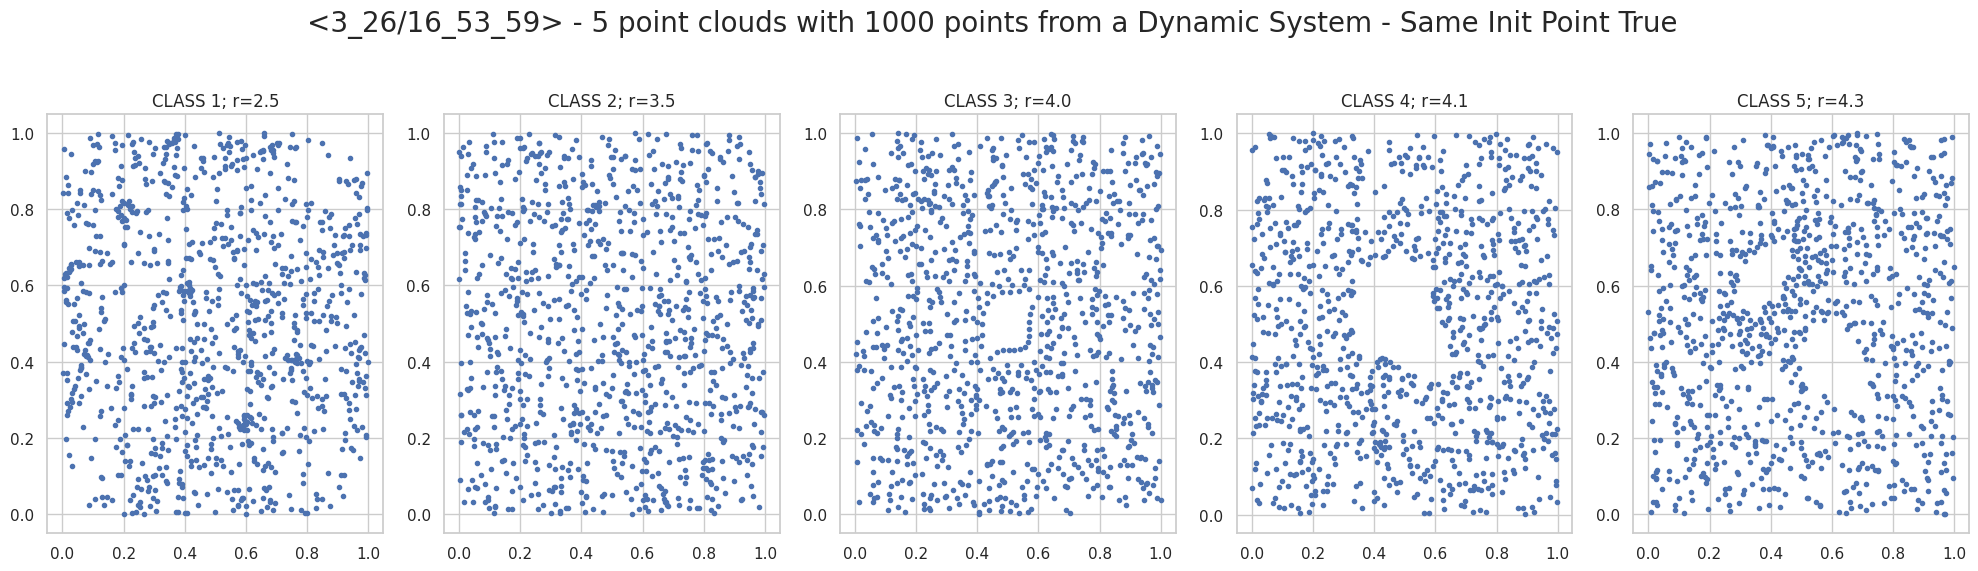

In [4]:
# init the 5 point clouds
def generate_orbits(n_points_per_orbit, params, same_init_point):
    # get current time
    now = time.time()
    now = time.localtime(now)
    orbit_folder = './ORBITS/'
    time_component = f'{now.tm_mon}_{now.tm_mday}/{now.tm_hour}_{now.tm_min}_{now.tm_sec}'
    save_folder_path = orbit_folder+time_component
    if not os.path.exists(save_folder_path):
        # Create the folder
        os.makedirs(save_folder_path)
        print(f"Folder '{save_folder_path}' created")

    # create point clouds
    ORBITS = np.zeros([len(params), n_points_per_orbit, 2])
    xcur_0, ycur_0 = np.random.rand(), np.random.rand() # not necesary to save the first one
    for id_pc, param in enumerate(params): # id_point_cloud
        if same_init_point:
            xcur, ycur = xcur_0, ycur_0 # not necesary to save the first one
        else:
            xcur, ycur =np.random.rand(), np.random.rand()
        for id_pt in range(n_points_per_orbit): # id_point
            xcur = (xcur + param * ycur * (1. - ycur)) % 1
            ycur = (ycur + param * xcur * (1. - xcur)) % 1
            ORBITS[id_pc, id_pt, :] = [xcur, ycur]
    print(f"ORBITS.shape = {ORBITS.shape}")
            
    data_path = save_folder_path+"/pt_coulds_data.pkl"
    # Save the array as a pickle file
    with open(data_path, 'wb') as f:
        pickle.dump(ORBITS, f)
    print(f"DATA SAVED")

    # Visualize point clouds
    
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=len(params), figsize=(20, 6))
    for i, ax in enumerate(axes): # each ax corresponds to one point_cloud
        x = ORBITS[i,:,0]
        y = ORBITS[i,:,1]
        ax.scatter(x, y, s=9)
        ax.set_title(f'CLASS {i+1}; r={params[i]}')

    # Show the figure
    plt.suptitle(f'<{time_component}> - {len(params)} point clouds with {n_points_per_orbit} points from a Dynamic System - Same Init Point {same_init_point}', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_path = save_folder_path+"/pt_coulds_plot.png"
    plt.savefig(plot_path)
    print(f"PLOT SAVED")
    plt.show()
    

    return ORBITS

params = [2.5, 3.5, 4.0, 4.1, 4.3]
n_points = 1000
same_init_point = True
orbits = generate_orbits(n_points, params, same_init_point)


PERSISTENCE DIAGRAMS with APLHA-COMPLEXES


 CLASS 0 	 -------------------------------


/home/andrea/.local/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


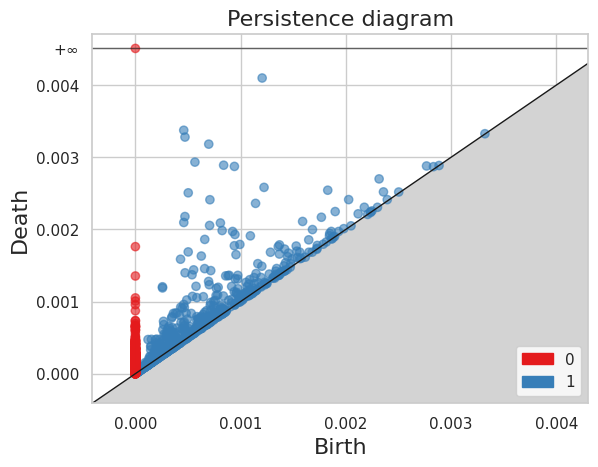


 CLASS 1 	 -------------------------------


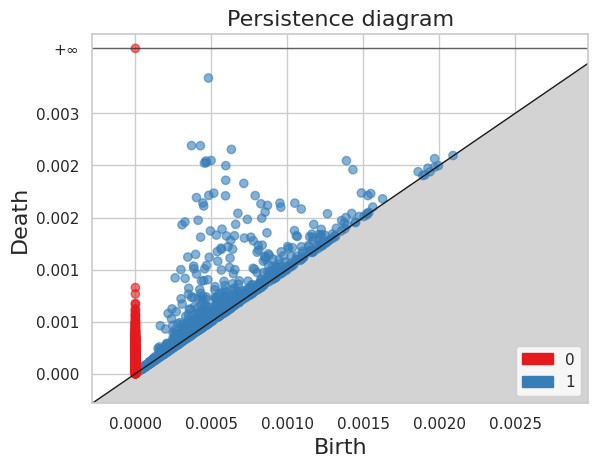


 CLASS 2 	 -------------------------------


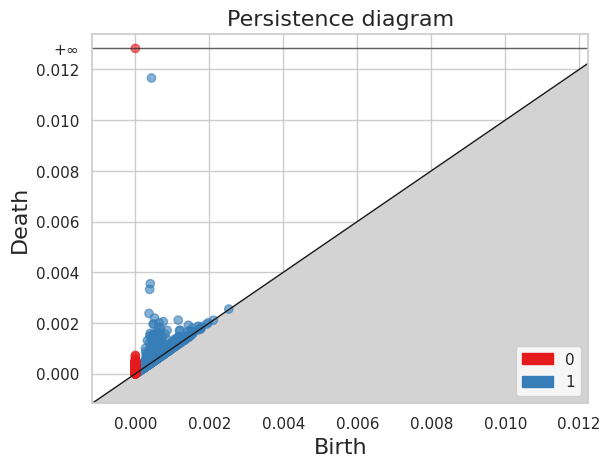


 CLASS 3 	 -------------------------------


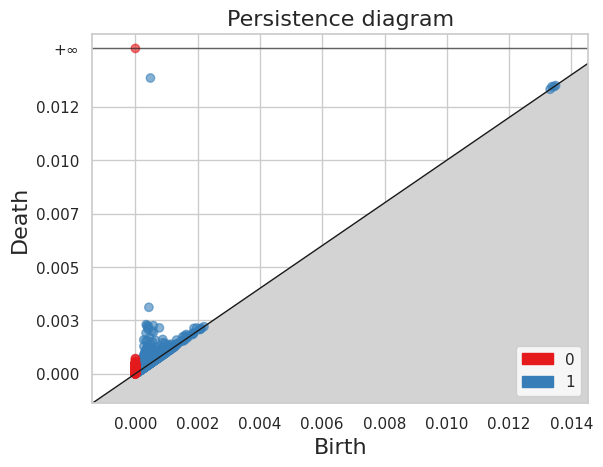


 CLASS 4 	 -------------------------------


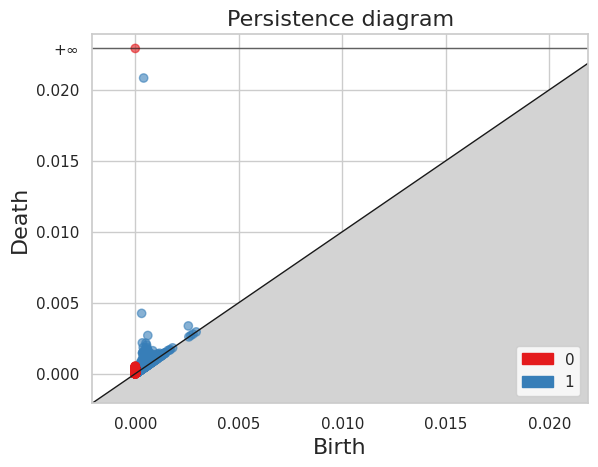

Clouds considered: [0, 1, 2, 3, 4]
5 complexes saved


In [3]:
import gudhi as gd
import matplotlib
plot_pd = True
persistences = {}

considered_clouds = sorted([0,1,2,3,4])

for i in considered_clouds:
    print(f"\n CLASS {i} \t -------------------------------")
    ac = gd.AlphaComplex(points=orbits[i,:,:])
    st = ac.create_simplex_tree()
    pers = st.persistence()*100
    if plot_pd:
        gd.plot_persistence_diagram(pers)
        plt.show()
    pers_dict = {
        'skeleton': ac,
        'complex': st,
        'persist': pers
    }
    persistences[i] = pers_dict
print(f"Clouds considered: {considered_clouds}\n{len(persistences)} complexes saved")

In [4]:
from itertools import product
from gudhi.wasserstein import wasserstein_distance

dimension_considered = 0
considered_clouds = sorted(considered_clouds)
# pairs of clouds

# all_pairs = list(filter(lambda x: x[0] <= x[1], product(persistences.keys(), repeat=2)))
all_pairs = list(product(persistences.keys(), repeat=2))
type_dist = 'bott'
dists = {}
for cl in considered_clouds: #init spots in the dict for distances
    dists[cl] = []

for idx, pair in enumerate(all_pairs):

    I0 = persistences[pair[0]]["complex"].persistence_intervals_in_dimension(dimension_considered)
    I1 = persistences[pair[1]]["complex"].persistence_intervals_in_dimension(dimension_considered)

    if type_dist == 'wass':
        dist = wasserstein_distance(I0, I1)
    else:
        dist = gd.bottleneck_distance(I0, I1)
        # gd.bottleneck_distance(I0, I1, 0.01) possible approximation
    dists[pair[0]].append(dist)

# visualize matrix of distances
print(f">>> Considered Dimension = {dimension_considered}")
print(f">>> \t DISTANCE = {type_dist}\n")
for k in dists.keys():
    print(f"{k} |", end='')
    vals = dists[k]
    print(f" - -  - - |"*(len(considered_clouds)-len(vals)), end='')
    for v in vals:
        print(f" {v:.6f} !",end='')
    print()

>>> Considered Dimension = 0
>>> 	 DISTANCE = bott

0 | 0.000000 ! 0.000880 ! 0.000880 ! 0.000880 ! 0.000880 !
1 | 0.000880 ! 0.000000 ! 0.000133 ! 0.000124 ! 0.000301 !
2 | 0.000880 ! 0.000133 ! 0.000000 ! 0.000047 ! 0.000197 !
3 | 0.000880 ! 0.000124 ! 0.000047 ! 0.000000 ! 0.000182 !
4 | 0.000880 ! 0.000301 ! 0.000197 ! 0.000182 ! 0.000000 !


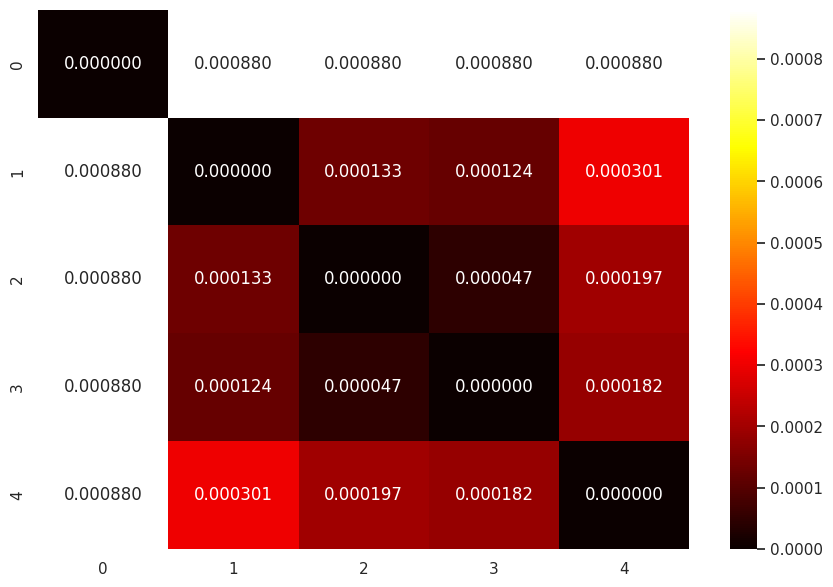

In [5]:
import seaborn as sns

data = []
for key in dists.keys():
    vals = dists[key]
    dat = [0]*(len(considered_clouds)-len(vals)) + vals
    data.append(dat)

plt.figure(figsize=(3 + 1.5*len(considered_clouds), 2 + 1*len(considered_clouds)))

# Plotting the heatmap with annotations
sns.heatmap(data, cmap='hot', annot=True, fmt=".6f", xticklabels=considered_clouds, yticklabels=considered_clouds, cbar=True)
plt.show()

> PD inspection

In [28]:
len(persistences)
for i in persistences:
    print(f'\n### {i = } ###')
    pers = persistences[i]["persist"]
    compl = persistences[i]["complex"]
    print(f'{len(pers) = }')
    print(f'{len(compl.persistence_intervals_in_dimension(0)) = }')
    print(f'{len(compl.persistence_intervals_in_dimension(1)) = }')
    print(pers[len(compl.persistence_intervals_in_dimension(1))-1:len(compl.persistence_intervals_in_dimension(1))+1])
    print(pers[-3:])



### i = 0 ###
len(pers) = 1875
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 875
[(1, (0.000385871961050217, 0.00038587199109211016)), (0, (0.0, inf))]
[(0, (0.0, 4.5894865276818694e-07)), (0, (0.0, 1.2045854620534612e-07)), (0, (0.0, 7.130280164321566e-08))]

### i = 1 ###
len(pers) = 1948
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 948
[(1, (0.0012005918664168733, 0.0012005918971095214)), (0, (0.0, inf))]
[(0, (0.0, 3.133705285573796e-07)), (0, (0.0, 1.9377727169998594e-07)), (0, (0.0, 8.164514137474905e-08))]

### i = 2 ###
len(pers) = 1967
len(compl.persistence_intervals_in_dimension(0)) = 1000
len(compl.persistence_intervals_in_dimension(1)) = 967
[(1, (0.0008908639320506242, 0.000890863993021065)), (0, (0.0, inf))]
[(0, (0.0, 1.0979176791503746e-06)), (0, (0.0, 6.399662294368658e-07)), (0, (0.0, 5.712761936696521e-07))]

### i = 3 ###
len(pers) = 1950
len(c